# 0. Imports

numpy pandas scikit-learn matplotlib

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt

# 1. Load the radiomics data

In [10]:
df = pd.read_csv(r"../datasets/ACDC_radiomics.csv")          # <- adjust path if needed
X   = df.drop(columns=["class"])                # radiomic features (642 columns + H/W)
y   = df["class"]   

# 2. Train / validation split (stratified)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = 0.20,
    stratify    = y,
    random_state= 42)

# 3‑A.  Non‑linear exploration with Kernel PCA

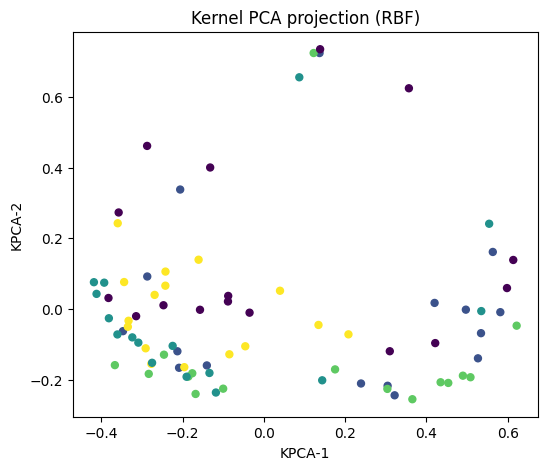

In [13]:
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=1e-3, random_state=42)
X_train_kpca = kpca.fit_transform(StandardScaler().fit_transform(X_train))
X_test_kpca  = kpca.transform(StandardScaler().fit_transform(X_test))

plt.figure(figsize=(6,5))
plt.scatter(X_train_kpca[:,0], X_train_kpca[:,1],
            c=pd.Categorical(y_train).codes, cmap="viridis", s=25)
plt.title("Kernel PCA projection (RBF)")
plt.xlabel("KPCA‑1"); plt.ylabel("KPCA‑2")
plt.show()

# 3‑B.  Support‑Vector Machine with RBF kernel

Fitting 5 folds for each of 16 candidates, totalling 80 fits
◆ Best SVM params : {'svc__C': 1, 'svc__gamma': 'scale'}
◆ CV F1‑macro     : 0.765

=== SVM – Test set performance ===
              precision    recall  f1-score   support

         DCM      0.429     0.750     0.545         4
         HCM      1.000     0.500     0.667         4
        MINF      0.500     0.500     0.500         4
         NOR      0.333     0.250     0.286         4
          RV      0.750     0.750     0.750         4

    accuracy                          0.550        20
   macro avg      0.602     0.550     0.550        20
weighted avg      0.602     0.550     0.550        20



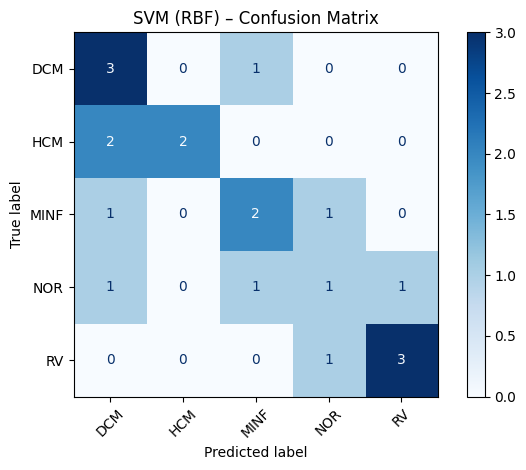

In [14]:
# Pipeline: Scaling → SVM
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf"))
])

# Hyper‑parameter search
param_grid = {
    "svc__C"    : [0.1, 1, 10, 100],
    "svc__gamma": ["scale", 1e-3, 1e-2, 1e-1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train, y_train)

print(f"◆ Best SVM params : {grid_svm.best_params_}")
print(f"◆ CV F1‑macro     : {grid_svm.best_score_:.3f}")

# Evaluate on held‑out data
y_pred = grid_svm.predict(X_test)
print("\n=== SVM – Test set performance ===")
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", xticks_rotation=45
)
plt.title("SVM (RBF) – Confusion Matrix"); plt.tight_layout(); plt.show()

# 3‑C.  Kernel Ridge as an alternative kernel method

Fitting 5 folds for each of 16 candidates, totalling 80 fits

◆ Best Kernel Ridge params : {'krr__estimator__alpha': 0.1, 'krr__estimator__gamma': 0.001}
◆ CV F1‑macro              : 0.799

=== Kernel Ridge – Test set performance ===
              precision    recall  f1-score   support

         DCM      0.750     0.750     0.750         4
         HCM      0.750     0.750     0.750         4
        MINF      0.750     0.750     0.750         4
         NOR      1.000     0.750     0.857         4
          RV      0.800     1.000     0.889         4

    accuracy                          0.800        20
   macro avg      0.810     0.800     0.799        20
weighted avg      0.810     0.800     0.799        20



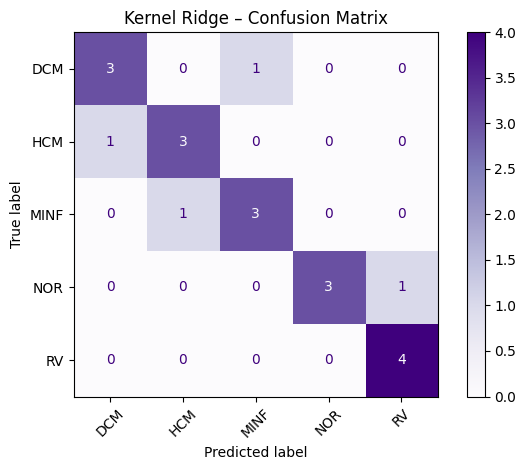

In [15]:
# Kernel Ridge outputs real‑valued scores.  We’ll use one‑vs‑rest strategy
from sklearn.multiclass import OneVsRestClassifier
kr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("krr", OneVsRestClassifier(
        KernelRidge(kernel="rbf")
    ))
])

kr_param_grid = {
    "krr__estimator__alpha" : [1e-2, 1e-1, 1, 10],
    "krr__estimator__gamma" : [1e-3, 1e-2, 1e-1, 1]
}
grid_krr = GridSearchCV(
    kr_pipe,
    kr_param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
grid_krr.fit(X_train, y_train)

print(f"\n◆ Best Kernel Ridge params : {grid_krr.best_params_}")
print(f"◆ CV F1‑macro              : {grid_krr.best_score_:.3f}")

y_pred_krr = grid_krr.predict(X_test)
print("\n=== Kernel Ridge – Test set performance ===")
print(classification_report(y_test, y_pred_krr, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_krr, cmap="Purples", xticks_rotation=45
)
plt.title("Kernel Ridge – Confusion Matrix"); plt.tight_layout(); plt.show()